# Setup

In [ ]:
%pip install numpy==1.23.5
%pip install torch==2.0.0

In [ ]:
# give colab permission to access drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Update these as required
repo_path = '/content/drive/MyDrive/github/subteams/LLMProbing'
odeformer_path = '/content/drive/MyDrive/aisc' # This is because I cloned the odeformer repo into my aisc folder

samples_path = '/content/drive/MyDrive/github/subteams/LLMProbing/probing_data/samples/r2_expt'
activations_path = '/content/drive/MyDrive/github/subteams/LLMProbing/probing_data/activations/r2_expt'
probes_path = '/content/drive/MyDrive/github/subteams/LLMProbing/probing_data/probes/r2_expt'

In [ ]:
import sys
import importlib
sys.path.append(repo_path)
sys.path.append(odeformer_path)

In [ ]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

In [ ]:
from odeformer.model import SymbolicTransformerRegressor
dstr = SymbolicTransformerRegressor(from_pretrained=True)
model_args = {'beam_size': 10, 'beam_temperature': 0.8}
dstr.set_model_args(model_args)

Found pretrained model at odeformer.pt
Loaded pretrained model


In [ ]:
%load_ext autoreload
%autoreload 2

# Train probe with solver

In [ ]:
from src.probes import LRProbe
from src.probes.utils import load_probe_from_path, eval_regression_probe, train_regression_probe_w_solver
from src.datasets.utils import split_dataset, get_d_in
from src.datasets import ActivationsDataset
from torch.utils.data import DataLoader
from experiments.utils import plot_scalar_predictions

In [ ]:
L7_r2_probes_path = f'{probes_path}/L7_probes_w_solver'

In [ ]:
full_dataset = ActivationsDataset(activations_path=activations_path,
                                  feature_label='r2_score',
                                  layer_idx=7,
                                  r2_threshold=0)

In [ ]:
train_dataset, val_dataset, test_dataset = split_dataset(full_dataset, lengths=[0.8, 0.1, 0.1])
val_dataloader = DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

d_in = get_d_in(train_dataset)

In [ ]:
solver_probe = LRProbe(d_in)

In [ ]:
solver_probe.hidden.weight.shape

torch.Size([1, 512])

In [ ]:
# acts, labels, ids = [], [], []
# for i in range(len(train_dataset)):
#     act, label, id = train_dataset[i]
#     acts.append(act.numpy())
#     labels.append(label.item())
#     ids.append(id)

# acts = np.array(acts)  # Convert to numpy arrays if needed
# labels = np.array(labels)

In [ ]:
# from sklearn.linear_model import Ridge

# sklearn_probe = Ridge(alpha=0.01, fit_intercept=False)
# sklearn_probe.fit(acts, labels)

# coeffs = sklearn_probe.coef_

In [ ]:
# with torch.no_grad():
#     solver_probe.hidden.weight.copy_(torch.tensor(coeffs).unsqueeze(0))

In [ ]:
solver_probe, losses, val_losses = train_regression_probe_w_solver(solver_probe,
                               train_dataset,
                               val_dataset)

In [ ]:
losses

[(1.5289708178521189,
  -125.24316373521789,
  0.2641976063283701,
  0.11622228226446296)]

In [ ]:
val_losses

[(1.5305389755964278,
  -96.36081850238332,
  0.1348790896159317,
  0.22358117499243235)]

In [ ]:
eval_regression_probe(solver_probe, test_dataloader)

(0.04223852059685972,
 0.14436272815008677,
 0.745524505883052,
 0.41048744844374596)

0.745524505883052

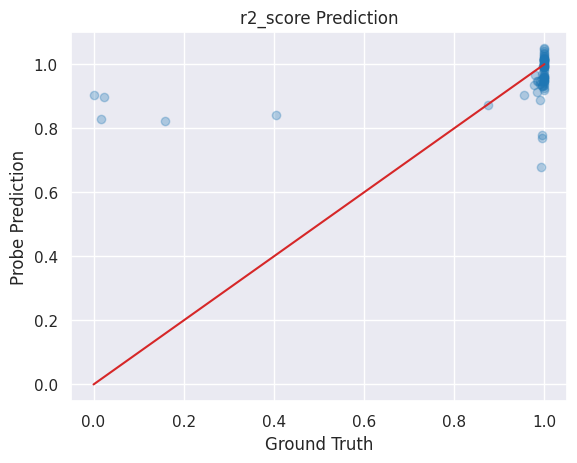

In [ ]:
fig, ax = plt.subplots()

plot_scalar_predictions(solver_probe, test_dataloader, ax, 'tab:blue', 'r2_score', 'R^2 Score')

# Redoing R^2 experiment

In [ ]:
from experiments.run_experiment import scalar_prediction_experiment_w_solver

In [ ]:
solver_r2_probes_path = f'{probes_path}/probes_w_solver'
layers = [i for i in range(4,16)]

In [ ]:
solver_r2_expt_results = scalar_prediction_experiment_w_solver('r2_score', activations_path, solver_r2_probes_path, \
                                                       layers=layers, \
                                                       r2_threshold=0)
# save experiment results
with open(f'{solver_r2_probes_path}/experiment_data.pt', 'wb') as f:
    pickle.dump(solver_r2_expt_results, f)


Training on each layer:   8%|▊         | 1/12 [00:32<05:58, 32.63s/it]

Regression probe trained on layer 4: Test Set Loss 0.06859186891141808
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/probing_data/probes/r2_expt/probes_w_solver/probe_r2_score_4_0.pt



Training on each layer:  17%|█▋        | 2/12 [00:59<04:52, 29.27s/it]

Regression probe trained on layer 5: Test Set Loss 0.03709747046964822
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/probing_data/probes/r2_expt/probes_w_solver/probe_r2_score_5_0.pt



Training on each layer:  25%|██▌       | 3/12 [01:23<04:01, 26.84s/it]

Regression probe trained on layer 6: Test Set Loss 0.04399016767188603
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/probing_data/probes/r2_expt/probes_w_solver/probe_r2_score_6_0.pt



Training on each layer:  33%|███▎      | 4/12 [01:48<03:29, 26.13s/it]

Regression probe trained on layer 7: Test Set Loss 0.04223852059685972
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/probing_data/probes/r2_expt/probes_w_solver/probe_r2_score_7_0.pt



Training on each layer:  42%|████▏     | 5/12 [02:15<03:03, 26.25s/it]

Regression probe trained on layer 8: Test Set Loss 0.03526353946662354
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/probing_data/probes/r2_expt/probes_w_solver/probe_r2_score_8_0.pt



Training on each layer:  50%|█████     | 6/12 [02:43<02:41, 26.87s/it]

Regression probe trained on layer 9: Test Set Loss 0.0527929709913163
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/probing_data/probes/r2_expt/probes_w_solver/probe_r2_score_9_0.pt



Training on each layer:  58%|█████▊    | 7/12 [03:06<02:08, 25.78s/it]

Regression probe trained on layer 10: Test Set Loss 0.055886715406990486
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/probing_data/probes/r2_expt/probes_w_solver/probe_r2_score_10_0.pt



Training on each layer:  67%|██████▋   | 8/12 [03:32<01:43, 25.89s/it]

Regression probe trained on layer 11: Test Set Loss 0.18484719141671355
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/probing_data/probes/r2_expt/probes_w_solver/probe_r2_score_11_0.pt



Training on each layer:  75%|███████▌  | 9/12 [03:56<01:15, 25.30s/it]

Regression probe trained on layer 12: Test Set Loss 0.11752151127047986
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/probing_data/probes/r2_expt/probes_w_solver/probe_r2_score_12_0.pt



Training on each layer:  83%|████████▎ | 10/12 [04:20<00:49, 24.82s/it]

Regression probe trained on layer 13: Test Set Loss 0.052779429446456444
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/probing_data/probes/r2_expt/probes_w_solver/probe_r2_score_13_0.pt



Training on each layer:  92%|█████████▏| 11/12 [04:49<00:26, 26.03s/it]

Regression probe trained on layer 14: Test Set Loss 0.08521449166952834
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/probing_data/probes/r2_expt/probes_w_solver/probe_r2_score_14_0.pt



Training on each layer: 100%|██████████| 12/12 [05:12<00:00, 26.05s/it]

Regression probe trained on layer 15: Test Set Loss 0.08182321810956182
Saved state dictionary to /content/drive/MyDrive/github/subteams/LLMProbing/probing_data/probes/r2_expt/probes_w_solver/probe_r2_score_15_0.pt


In [ ]:
solver_r2_expt_results

,layer,test_loss,final_train_loss,final_val_loss,test_r2,test_spearman,test_pearson
0,4,0.068592,"(18.809667156580257, -1552.065538373229, 0.265...","(16.770705938156848, -1065.820014160221, 0.253...",-0.389484,0.128237,0.280661
1,5,0.037097,"(45.994267833645125, -3796.627677662813, -0.18...","(36.53575635331528, -2323.1166967619315, -0.11...",0.248506,0.343544,0.541671
2,6,0.043990,"(2.281289546011591, -187.36017476559562, 0.124...","(2.075634767760833, -131.03551828727242, 0.088...",0.108879,0.429249,0.353534
3,7,0.042239,"(0.12400150645081857, -9.238483518074556, 0.14...","(0.12545447836232293, -6.980424591010031, 0.06...",0.144363,0.745525,0.410487
4,8,0.035264,"(0.5669029616642062, -45.80771049396443, 0.062...","(0.5523632649378851, -34.13699471887967, -0.00...",0.285657,0.532280,0.579414
5,9,0.052793,"(0.48586943716826164, -39.11698212666158, -0.1...","(0.4964354075953209, -30.579305251209632, -0.1...",-0.069442,0.230869,0.298250
6,10,0.055887,"(1.9364112111488825, -158.88446249672103, -0.0...","(1.5680673140039048, -98.74807725029618, 0.105...",-0.132113,0.332364,0.565065
7,11,0.184847,"(3.4605774783868966, -284.7309277606277, 0.135...","(3.3962427379687625, -215.04217963752987, -0.0...",-2.744500,0.045790,0.037970
8,12,0.117522,"(4.308304936580422, -354.7255894316189, 0.0097...","(3.64078449010849, -230.59799924643153, 0.1860...",-1.380666,0.025249,0.344419
9,13,0.052779,"(0.2388644259179476, -18.722417565017224, 0.00...","(0.2722287020080451, -16.317043051095702, -0.0...",-0.069167,0.294270,0.515054


In [ ]:
from experiments.utils import summarise_experiment, plot_from_summary

In [ ]:
solver_r2_expt_summary = summarise_experiment(solver_r2_expt_results, incl_extras=True)
solver_r2_expt_summary

,layer,r2_mean,r2_std,spearman_mean,spearman_std,pearson_mean,pearson_std,loss_mean,loss_std
0,4,-0.389484,NaN,0.128237,NaN,0.280661,NaN,0.068592,NaN
1,5,0.248506,NaN,0.343544,NaN,0.541671,NaN,0.037097,NaN
2,6,0.108879,NaN,0.429249,NaN,0.353534,NaN,0.043990,NaN
3,7,0.144363,NaN,0.745525,NaN,0.410487,NaN,0.042239,NaN
4,8,0.285657,NaN,0.532280,NaN,0.579414,NaN,0.035264,NaN
5,9,-0.069442,NaN,0.230869,NaN,0.298250,NaN,0.052793,NaN
6,10,-0.132113,NaN,0.332364,NaN,0.565065,NaN,0.055887,NaN
7,11,-2.744500,NaN,0.045790,NaN,0.037970,NaN,0.184847,NaN
8,12,-1.380666,NaN,0.025249,NaN,0.344419,NaN,0.117522,NaN
9,13,-0.069167,NaN,0.294270,NaN,0.515054,NaN,0.052779,NaN


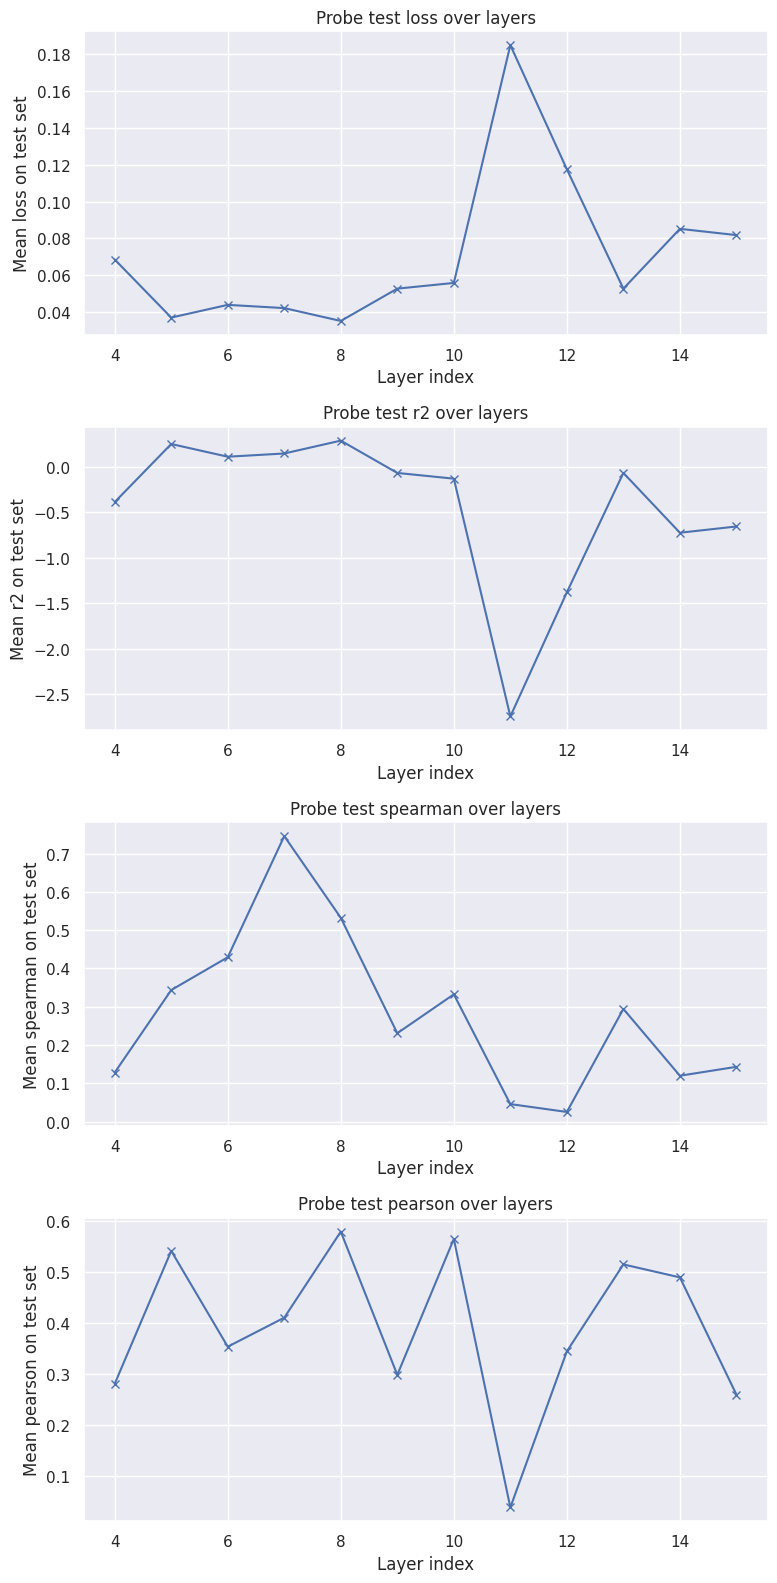

In [ ]:
plot_from_summary(solver_r2_expt_summary, incl_extras=True)